## Visão computacional

Hoje vamos falar um pouco sobre técnicas de _visão computacional_, isto é, extrair informações de _imagens_. Vamos utilizar o _hello world_ da visão computacional, que é o dataset MNIST, e sua variação de itens de vestuário Fashion-MNIST.

### MNIST

In [33]:
import torchvision
batch_size = 256

In [34]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Treino
mnist_train = torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307), (0.3081))]))
df_train = pd.DataFrame(mnist_train.data.flatten(start_dim=1, end_dim=2))


df_train = pd.concat([df_train, pd.DataFrame(mnist_train.targets.cpu(), columns=['target'])], axis=1)
df_train.dropna(inplace=True)
model_cols = [c for c in df_train.columns if c!='target']
train_features = torch.tensor(df_train[model_cols].values.astype(np.float32)).cuda()
# Trocar o formato da target para dummies
train_target = torch.tensor(pd.get_dummies(df_train['target'], prefix='target').values.astype(np.float32)).cuda()
train_tensor = TensorDataset(train_features, train_target)
train_dl = DataLoader(dataset=train_tensor, batch_size=batch_size, shuffle=True)


# Teste
mnist_test = torchvision.datasets.MNIST('/data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307), (0.3081))]))
df_test = pd.DataFrame(mnist_test.data.flatten(start_dim=1, end_dim=2))

df_test = pd.concat([df_test, pd.DataFrame(mnist_test.targets.cpu(), columns=['target'])], axis=1)
df_test.dropna(inplace=True)
model_cols = [c for c in df_test.columns if c!='target']
test_features = torch.tensor(df_test[model_cols].values.astype(np.float32)).cuda()
test_target = torch.tensor(pd.get_dummies(df_test['target'], prefix='target').values.astype(np.float32)).cuda()
test_tensor = TensorDataset(test_features, test_target)
test_dl = DataLoader(dataset=test_tensor, batch_size=batch_size, shuffle=True)

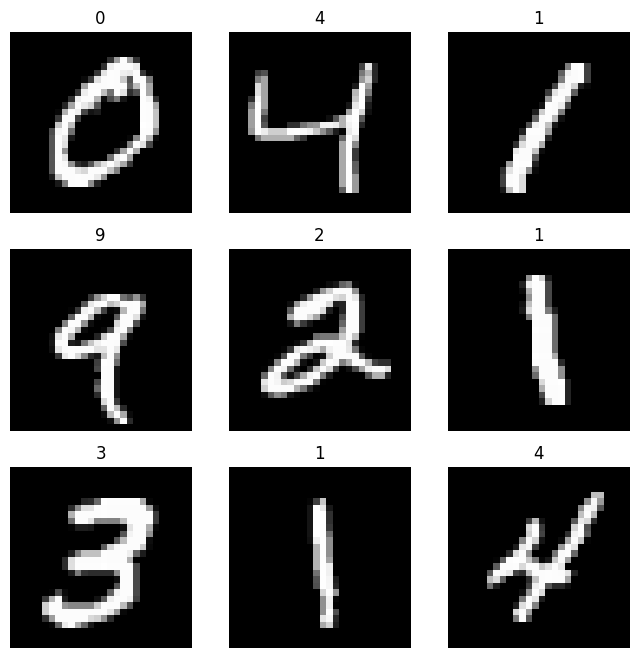

In [37]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    pixels = df_train.iloc[i].values[:-1].reshape((28, 28))
    array = np.array(pixels, dtype=np.uint8)
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(df_train.iloc[i]['target'])
    plt.imshow(array, cmap='gray')
    plt.axis('off')
plt.show()

In [4]:
%%time
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

rfr = RandomForestClassifier()
cross_val_score(rfr, df_train[model_cols], df_train['target'], cv=5, scoring='accuracy', n_jobs=-1)

CPU times: total: 547 ms
Wall time: 37 s


array([0.96875   , 0.96608333, 0.964     , 0.96308333, 0.97108333])

Obtivemos 96% de acurácia média na validação cruzada! Vamos ajustar o modelo e verificar no conjunto de teste:

In [5]:
%%time
from sklearn.metrics import accuracy_score
rfr.fit(df_train[model_cols], df_train['target'])
accuracy_score(df_test['target'], rfr.predict(df_test[model_cols]))

CPU times: total: 32.2 s
Wall time: 32.2 s


0.97

Vamos então ajustar uma rede neural simples, fully-connected, e comparar o desempenho:

In [6]:
n_epochs = 3
learning_rate = 0.005
momentum = 0.2
torch.manual_seed(42);

In [7]:
import torch.nn as nn
import torch.optim as optim

In [67]:
from torch import nn

# Definindo o modelo
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.feedforward = nn.Sequential(
                               nn.LayerNorm(784),
                               nn.Linear(784, 512),
                               nn.LeakyReLU(),
                               nn.Linear(512, 128),
                               nn.LeakyReLU(),
                               nn.Linear(128, 32),
                               nn.LeakyReLU(),
                               nn.Linear(32, 10)
                           )

    def forward(self, x):
        return self.feedforward(x)


model = NeuralNetwork().cuda()
print(f'Total de parâmetros treináveis: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Total de parâmetros treináveis: 473610


In [9]:
# Hiperparâmetros do otimizador
learning_rate = 0.01
momentum = 0.1

# Loss
loss_fn = nn.CrossEntropyLoss()

# Otimizador
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [10]:
def trainloop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.cuda(), y.type(torch.float32).cuda()

        # Calcula a loss
        prediction = model(X).type(torch.float32)
        loss = loss_fn(prediction, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [11]:
from sklearn.metrics import accuracy_score
def evaluate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    accuracy = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.cuda(), y.type(torch.float32).cuda()
            pred = model(X)
            test_loss = test_loss + loss_fn(pred, y)
            # Necessário tomar argmax para a accuracy_score()
            accuracy = accuracy + accuracy_score(torch.argmax(y, dim=1).cpu(), torch.argmax(pred, dim=1).cpu())
    test_loss = test_loss / num_batches
    accuracy = accuracy / num_batches
    return accuracy, test_loss

In [12]:
from IPython.display import clear_output
import time

epochs = 1
start_time = time.time()
for i in range(epochs):
    start_epoch_time = time.time()
    trainloop(train_dl, model, loss_fn, optimizer)
    train_metric_str = evaluate(train_dl, model, loss_fn)
    test_metric_str = evaluate(test_dl, model, loss_fn)
    clear_output(wait=True)
    print(f"Epoch {i+1}\n-------------------------------")
    print(f'Desempenho treino: {train_metric_str}')
    print(f'Desempenho teste: {test_metric_str}')
    end = time.time()
    print(f'Tempo última epoch: {np.round((end-start_epoch_time), 2)}s')
    print(f'Tempo total: {np.round((end-start_time), 2)}s ({np.round(((end-start_time)/60), 2)}min)')
print('Rede treinada.')

Epoch 1
-------------------------------
Desempenho treino: (0.6158244680851064, tensor(1.6559, device='cuda:0'))
Desempenho teste: (0.62373046875, tensor(1.6481, device='cuda:0'))
Tempo última epoch: 1.24s
Tempo total: 1.24s (0.02min)
Rede treinada.


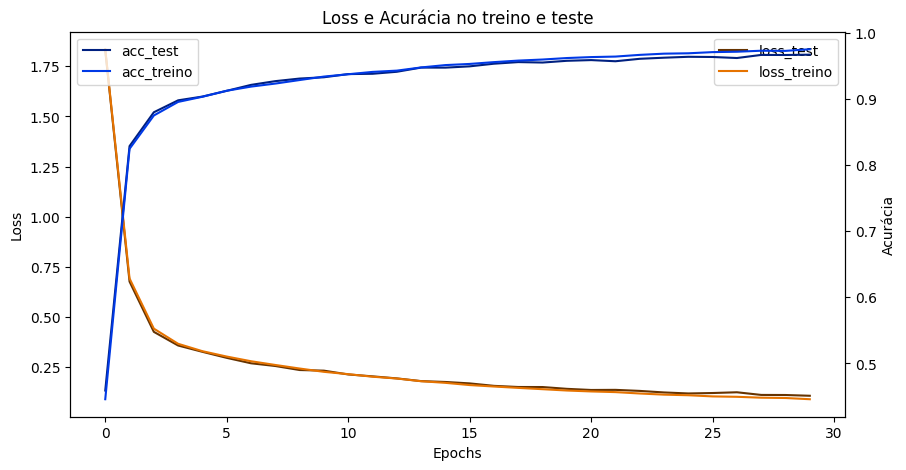

Rede treinada.
Última loss: 0.10522563755512238
Última Acurácia (teste): 0.96689453125


In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

model = NeuralNetwork().cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

epochs = 30
start_time = time.time()
train_accs, train_losses = [], []
test_accs, test_losses = [], []

for i in range(epochs):
    start_epoch_time = time.time()
    trainloop(train_dl, model, loss_fn, optimizer)
    train_acc, train_loss = evaluate(train_dl, model, loss_fn)
    test_acc, test_loss = evaluate(test_dl, model, loss_fn)
    train_accs += [train_acc]
    train_losses += [train_loss.cpu()]
    test_accs += [test_acc]
    test_losses += [test_loss.cpu()]

    # Plottando gráficos de loss e acc
    fig, ax1 = plt.subplots(figsize=(10, 5))
    plt.title('Loss e Acurácia no treino e teste')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.plot([t for t in test_losses], label='loss_test', c='#663300')
    ax1.plot([t for t in train_losses], label='loss_treino', c='#e67300')
    ax1.legend()
    ax2 = ax1.twinx()
    ax2.set_ylabel('Acurácia')
    ax2.plot([t for t in test_accs], label='acc_test', c='#002080')
    ax2.plot([t for t in train_accs], label='acc_treino', c='#0039e6')
    ax2.legend()
    plt.show()
    if i != epochs-1:
        clear_output(wait=True)

print('Rede treinada.')
print(f'Última loss: {test_loss.cpu()}')
print(f'Última Acurácia (teste): {test_acc}')

## Fashion-MNIST

In [38]:
import pandas as pd
df_train = pd.read_csv('data/fashion-mnist_train.csv').dropna()
df_test = pd.read_csv('data/fashion-mnist_test.csv').dropna()

In [41]:
dic_itens = {0:'T-shirt/Top',
             1:'Trouser',
             2:'Pullover',
             3:'Dress',
             4:'Coat',
             5:'Sandal',
             6:'Shirt',
             7:'Sneaker',
             8:'Bag',
             9:'Ankle Boot'}

In [42]:
model_cols = [c for c in df_train.columns if c!='label']

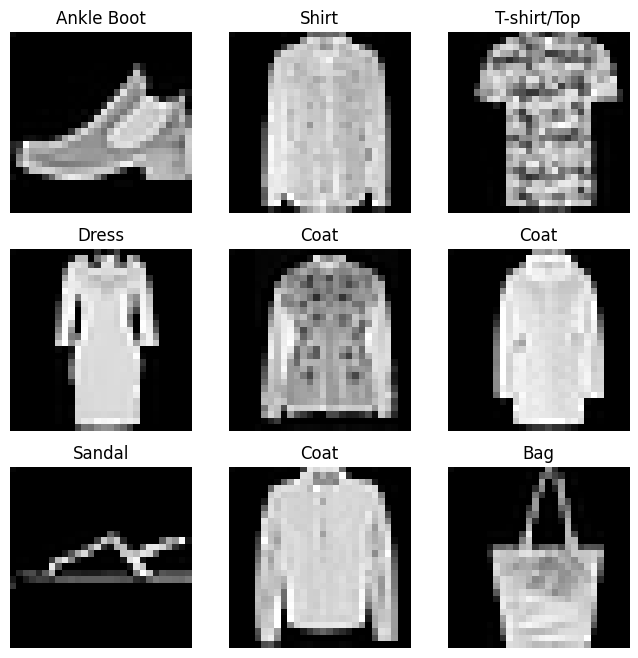

In [43]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    pixels = df_train.iloc[i].values[:-1].reshape((28, 28))
    array = np.array(pixels, dtype=np.uint8)
    ax = fig.add_subplot(rows, columns, i)
    ax.set_title(dic_itens[df_train.iloc[i]['label']])
    plt.imshow(array, cmap='gray')
    plt.axis('off')
plt.show()

In [18]:
batch_size = 256

train_features = torch.tensor(df_train[model_cols].values.astype(np.float32)).cuda()
# Trocar o formato da target para dummies
train_target = torch.tensor(pd.get_dummies(df_train['label'], prefix='label').values.astype(np.float32)).cuda()
train_tensor = TensorDataset(train_features, train_target)
train_dl = DataLoader(dataset=train_tensor, batch_size=batch_size, shuffle=True)


# Teste
test_features = torch.tensor(df_test[model_cols].values.astype(np.float32)).cuda()
test_target = torch.tensor(pd.get_dummies(df_test['label'], prefix='label').values.astype(np.float32)).cuda()
test_tensor = TensorDataset(test_features, test_target)
test_dl = DataLoader(dataset=test_tensor, batch_size=batch_size, shuffle=True)

In [19]:
%%time
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

rfr = RandomForestClassifier()
cross_val_score(rfr, df_train[model_cols], df_train['label'], cv=5, scoring='accuracy', n_jobs=-1)

CPU times: total: 1.2 s
Wall time: 1min 16s


array([0.88166667, 0.88033333, 0.88158333, 0.87866667, 0.88283333])

In [20]:
%%time
from sklearn.metrics import accuracy_score
rfr.fit(df_train[model_cols], df_train['label'])
accuracy_score(df_test['label'], rfr.predict(df_test[model_cols]))

CPU times: total: 1min 19s
Wall time: 1min 19s


0.8832

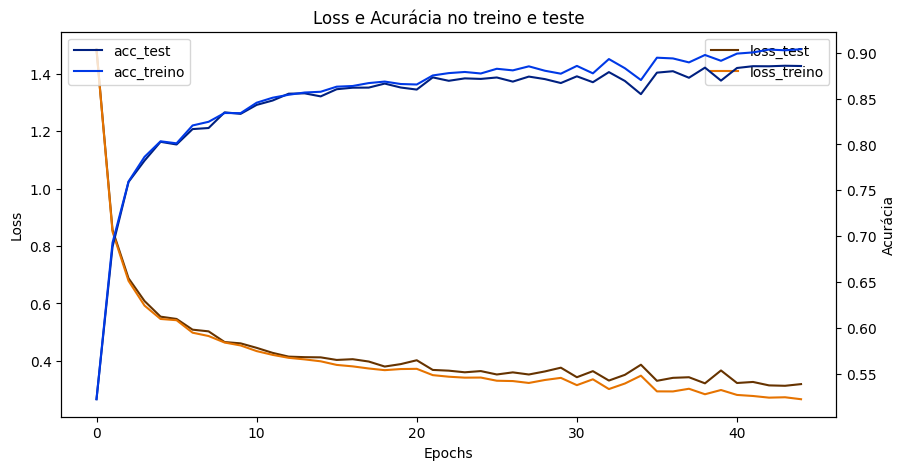

Rede treinada.
Última loss: 0.31929299235343933
Última Acurácia: 0.88544921875
CPU times: total: 3min 9s
Wall time: 53.9 s


In [21]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline

model = NeuralNetwork().cuda()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

epochs = 45
start_time = time.time()
train_accs, train_losses = [], []
test_accs, test_losses = [], []

for i in range(epochs):
    start_epoch_time = time.time()
    trainloop(train_dl, model, loss_fn, optimizer)
    train_acc, train_loss = evaluate(train_dl, model, loss_fn)
    test_acc, test_loss = evaluate(test_dl, model, loss_fn)
    train_accs += [train_acc]
    train_losses += [train_loss.cpu()]
    test_accs += [test_acc]
    test_losses += [test_loss.cpu()]

    # Plottando gráficos de loss e roc-auc
    fig, ax1 = plt.subplots(figsize=(10, 5))
    plt.title('Loss e Acurácia no treino e teste')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.plot([t for t in test_losses], label='loss_test', c='#663300')
    ax1.plot([t for t in train_losses], label='loss_treino', c='#e67300')
    ax1.legend()
    ax2 = ax1.twinx()
    ax2.set_ylabel('Acurácia')
    ax2.plot([t for t in test_accs], label='acc_test', c='#002080')
    ax2.plot([t for t in train_accs], label='acc_treino', c='#0039e6')
    ax2.legend()
    plt.show()
    if i != epochs-1:
        clear_output(wait=True)

print('Rede treinada.')
print(f'Última loss: {test_loss.cpu()}')
print(f'Última Acurácia: {test_acc}')

## Convolução

A convolução é uma operação matemática que pode ser vista como um produto de funções ponto a ponto, como uma espécie de janela móvel:

<div>
    <br>
    <center>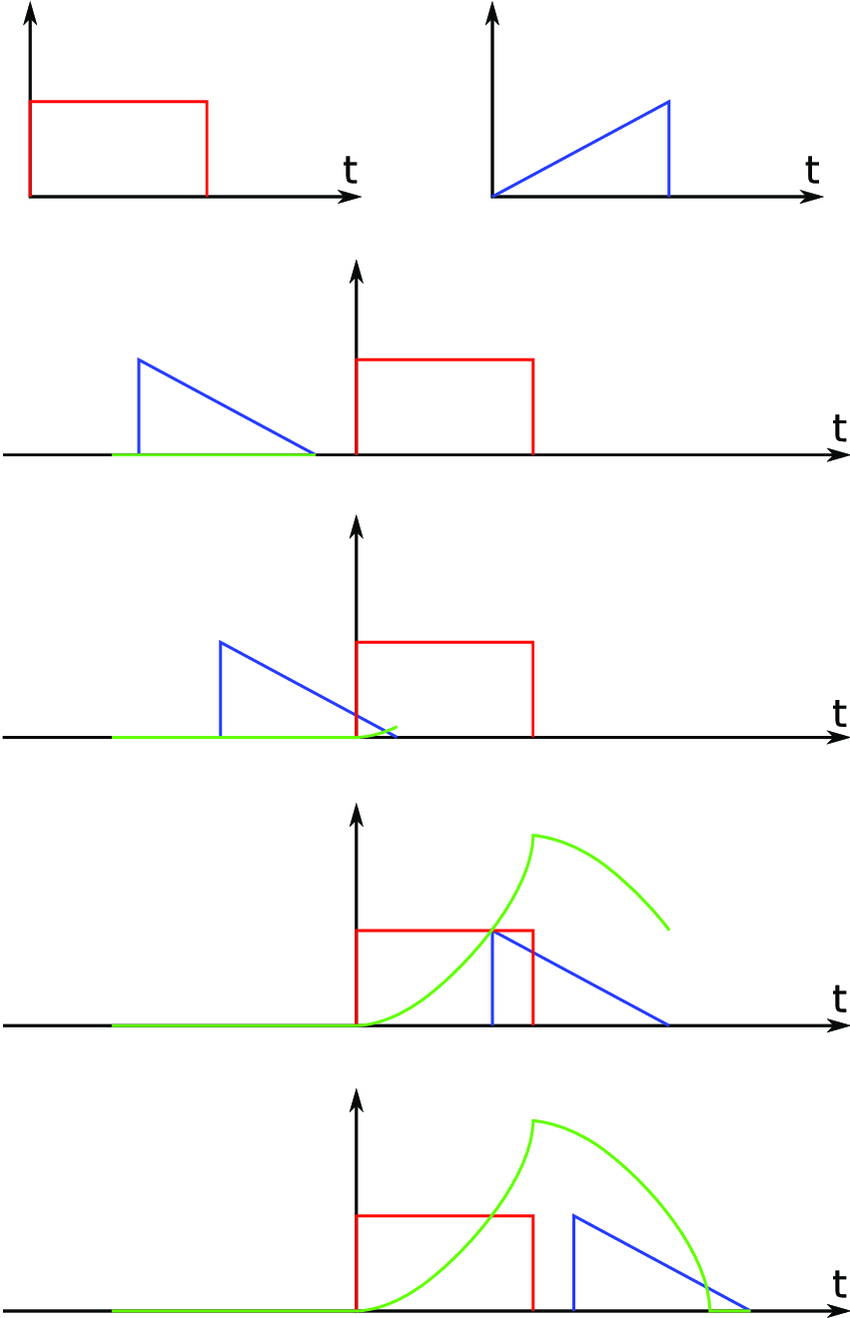</center></div>
    
Nas redes neurais, uma das partes da convolução é a amostra e a outra parte é o _filtro_, com pesos que são aprendidos durante o treino. Estamos interessados em uma convolução *bidimensional* para processar imagens, então nosso filtro pode ser representado por uma matriz e a convolução é realizada "deslizando" essa matriz sobre a imagem, multiplicando cada pixel pelo peso do correspondente do filtro, somando e guardando os resultados:

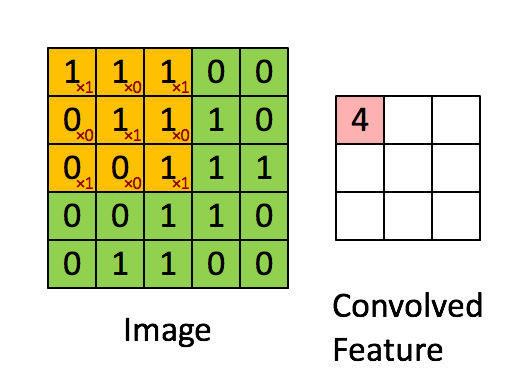



##### Max Pooling

Outro conceito relevante é o _max pooling_, que consiste em reduzir a "resolução" dos dados amostrando o pixel de maior valor em janelas de tamanho fixo:

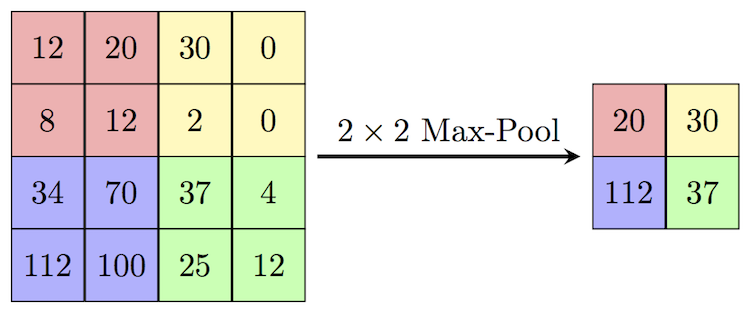


Também é possível utilizar outras abordagens como _average pooling_ e _min pooling_.

Leitura recomendada (Universidade de Stanford): https://cs231n.github.io/convolutional-networks/

In [23]:
import torch.nn.functional as F
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32,64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28).float()
        x = F.relu(self.conv1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.view(-1, 3*3*64)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

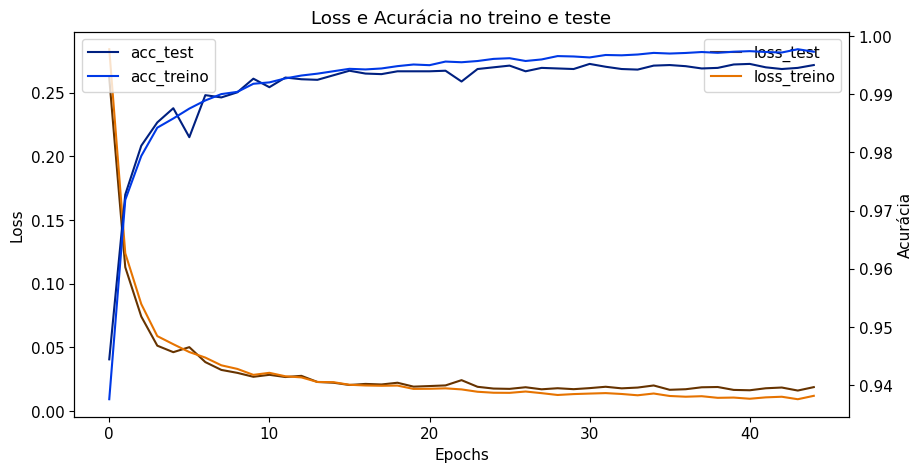

Rede treinada.
Última loss: 0.01868261955678463
Última Acurácia: 0.99501953125
CPU times: total: 3min 31s
Wall time: 1min 29s


In [68]:
%%time
import matplotlib.pyplot as plt
import torch
import time
%matplotlib inline

model = ConvNet().cuda()
print(f'Total de parâmetros treináveis: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

epochs = 45
start_time = time.time()
train_accs, train_losses = [], []
test_accs, test_losses = [], []

for i in range(epochs):
    start_epoch_time = time.time()
    trainloop(train_dl, model, loss_fn, optimizer)
    train_acc, train_loss = evaluate(train_dl, model, loss_fn)
    test_acc, test_loss = evaluate(test_dl, model, loss_fn)
    train_accs += [train_acc]
    train_losses += [train_loss.cpu()]
    test_accs += [test_acc]
    test_losses += [test_loss.cpu()]

    # Plottando gráficos de loss e accuracy
    fig, ax1 = plt.subplots(figsize=(10, 5))
    plt.title('Loss e Acurácia no treino e teste')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.plot([t for t in test_losses], label='loss_test', c='#663300')
    ax1.plot([t for t in train_losses], label='loss_treino', c='#e67300')
    ax1.legend()
    ax2 = ax1.twinx()
    ax2.set_ylabel('Acurácia')
    ax2.plot([t for t in test_accs], label='acc_test', c='#002080')
    ax2.plot([t for t in train_accs], label='acc_treino', c='#0039e6')
    ax2.legend()
    plt.show()
    if i != epochs-1:
        clear_output(wait=True)

print('Rede treinada.')
print(f'Última loss: {test_loss.cpu()}')
print(f'Última Acurácia: {test_acc}')

Obtivemos um ótimo salto de desempenho utilizando uma rede convolucional! Também é importante notar que a quantidade de parâmetros 

In [65]:
model = ConvNet()

In [66]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

228010

## Modelos pré-treinados

##### YOLOv5
Vamos carregar o YOLO (You Only Look Once) v5 (https://github.com/ultralytics/yolov5). Este é um modelo de visão computacional open source que está disponível pré-treinado para nossa conveniência no pytorch. Ele foi treinado no dataset _COCO_, da Microsoft, que é um dos datasets mais populares de visão computacional e comumente tomado como benchmark de modelos. Para utilizar o YOLO, basta instalar a biblioteca dos desenvolvedores e carregar o modelo:

In [ ]:
!pip install ultralytics

In [44]:
# Carregando o modelo
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\Danihell/.cache\torch\hub\ultralytics_yolov5_master


requirements: Ultralytics requirements ['pillow>=10.3.0', 'setuptools>=65.5.1'] not found, attempting AutoUpdate...
requirements: ❌ AutoUpdate skipped (offline)


YOLOv5  2024-4-28 Python-3.10.11 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


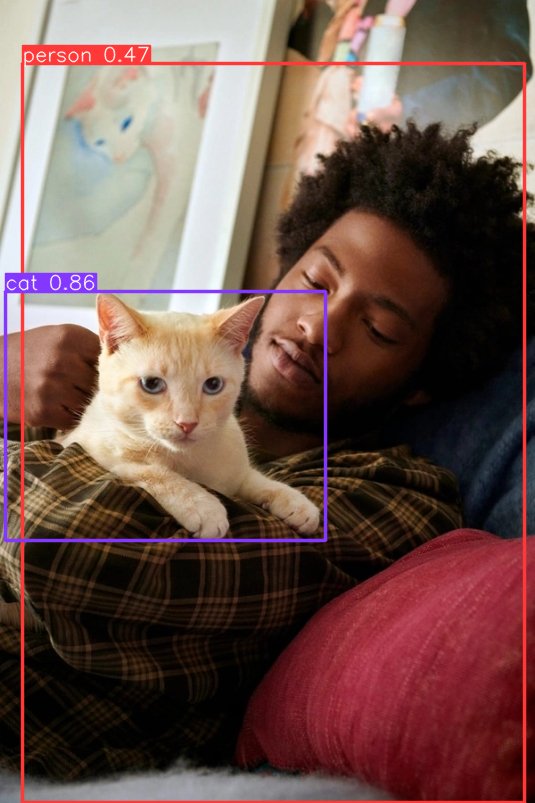

In [49]:
# Rodando inferência do modelo de uma imagem na web e plottando
results = model('https://cdn.sanity.io/images/7skkgjh0/production/1f775d0ee43d4b4ecb63aedbe0a384d43d069c0c-1120x1680.jpg?w=535&h=803&q=100&fit=max&dpr=1')
results.show()

Este objeto `model` é uma classe que "empacota" algumas conveniências (como processar uma imagem da web) em torno de algumas redes neurais do pytorch. Note as definições das camadas convolucionais:

In [56]:
# Iniciando captura da webcam
import cv2
cap = cv2.VideoCapture(0)

In [57]:
# Loop infinito inferindo frame a frame da webcam
from IPython.display import clear_output
import numpy as np
while True:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = model(frame);
    results.show()
    display(results)
    clear_output(wait=True)

KeyboardInterrupt: 

In [55]:
cap.release()

##### YOLOv8
Vamos agora carregar o YOLOv8, mais recente e com melhor desempenho. Precisamos estar logados no Huggingface e instalar outra biblioteca dos mesmos desenvolvedores:

In [69]:
!pip install ultralyticsplus


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [59]:
from ultralyticsplus import YOLO, render_result
torch.cuda.set_device(0)

# Username do Huggingface
model = YOLO('Bulrok/yolov8n.pt').cuda()

# Non-Max Supression
model.overrides['conf'] = 0.25  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000

In [64]:
%matplotlib inline
while True:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = model.predict(frame, imgsz=640, **{'verbose':False})[0]
    image = render_result(model=model, image=frame, result=results)
    display(image)
    clear_output(wait=True)

KeyboardInterrupt: 

### Exercícios
- Treine outra rede neural convolucional no dataset MNIST (tradicional) e compare com os desempenhos dos outros modelos ajustados (Random Forest e MLP).
- Treine uma rede neural convolucional no dataset Fashion-MNIST e atinja um desempenho consistente de 93% de acurácia.